In [16]:
# Import dependencies 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sqlite3 as sqlite
import psycopg2
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

"""
# Configuration
#"db-path": Path(".\dbs\test_1000cids.db")
CONFIG = {"db-path": Path("../dbs/sqlite3_test.db")}

# connect to the local DB
db_con = sqlite.connect(CONFIG["db-path"])
"""

plt.rcParams["figure.figsize"] = (10,6)

db_con = psycopg2.connect(
    host="localhost",
    database="cid_hoarder",
    user="hoarder",
    password="password")

    success_att  count  aggregation  % cids
0             6      1            1   0.001
1             7      3            4   0.004
2             8      6           10   0.010
3             9      7           17   0.017
4            10     15           32   0.032
5            11     24           56   0.056
6            12     58          114   0.114
7            13     62          176   0.176
8            14     83          259   0.259
9            15    108          367   0.367
10           16    133          500   0.500
11           17    160          660   0.660
12           18    141          801   0.801
13           19    130          931   0.931
14           20     69         1000   1.000


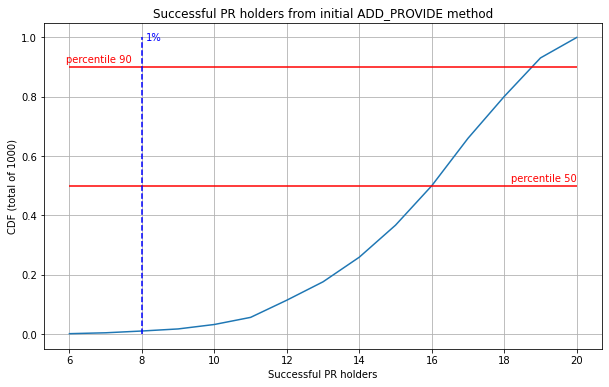

In [8]:
# Get the number of successfull ADD_PR 
pobj = pd.read_sql_query("select success_att, count(success_att) from fetch_results where fetch_round=0 group by success_att order by success_att ASC", db_con)

# init empty array for aggregation column 
agg_array = []
for i, row in pobj.iterrows():
    agg_array.append(0)
pobj["aggregation"] = agg_array


aggregation = 0
# get the aggregation of the success ratio 
for i, row in pobj.iterrows():
    aggregation += row['count']
    pobj.at[i,'aggregation'] = aggregation
    
# get the percentage of success attempts 
pobj["% cids"] = pobj["aggregation"] / aggregation

print(pobj)

per_1 = {'smalest_value': 0.0, 'x': 0.0}

for i, row in pobj.iterrows():
    if row['% cids'] >= 0.01:
        per_1['smales_value'] = row['% cids']
        per_1['x'] = row['success_att']
        break


plt.plot(pobj["success_att"],pobj["% cids"])
plt.title("Successful PR holders from initial ADD_PROVIDE method")
plt.xlabel("Successful PR holders")
plt.ylabel(f"CDF (total of {aggregation})")

# Lines
plt.hlines(y=[0.50], xmin=pobj.iloc[0]['success_att'], xmax=pobj.iloc[len(pobj)-1]['success_att'], color='r', linestyle='-', label='50%')
plt.text(pobj.iloc[len(pobj)-1]['success_att'], 0.525, 'percentile 50', ha='right', va='center', color='r')
plt.hlines(y=[0.90], xmin=pobj.iloc[0]['success_att'], xmax=pobj.iloc[len(pobj)-1]['success_att'], color='r', linestyle='-', label='50%')
plt.text(pobj.iloc[0]['success_att']-0.1, 0.925, 'percentile 90', ha='left', va='center', color='r')

plt.vlines(x=per_1['x'], ymin=0, ymax=1, linestyle='--', color='b')
plt.text(per_1['x']+0.1, 1, '1%', ha='left', va='center', color='b')

plt.grid()

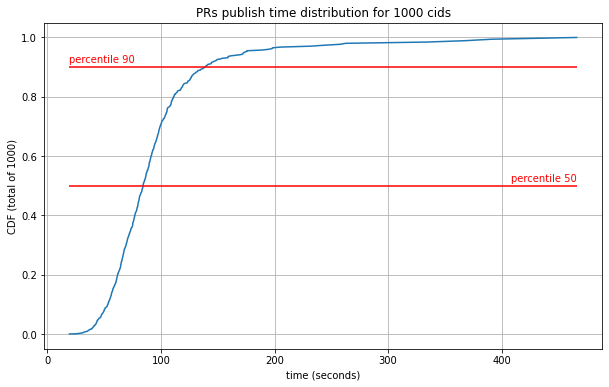

In [14]:
# Get the time to the IPFS DHT Provide method
pobj = pd.read_sql_query("select provide_time from cid_info order by provide_time ASC", db_con)

# init empty array for aggregation column 
agg_array = []
for i, row in pobj.iterrows():
    agg_array.append(0)
pobj["aggregation"] = agg_array

aggregation = 0
# get the aggregation of the success ratio 
for i, row in pobj.iterrows():
    aggregation += row['provide_time']
    pobj.at[i,'aggregation'] = aggregation
    
# get the percentage of success attempts 
pobj["cdf"] = pobj["aggregation"] / aggregation
pobj["provide_time"] = pobj["provide_time"] / 1000 # convert to seconds

plt.plot(pobj["provide_time"],pobj["cdf"])
plt.title(f'PRs publish time distribution for {len(pobj)} cids')
plt.xlabel("time (seconds)")
plt.ylabel(f"CDF (total of {len(pobj)})")

# Lines
plt.hlines(y=[0.50], xmin=pobj.iloc[0]['provide_time'], xmax=pobj.iloc[len(pobj)-1]['provide_time'], color='r', linestyle='-', label='50%')
plt.text(pobj.iloc[len(pobj)-1]['provide_time'], 0.525, 'percentile 50', ha='right', va='center', color='r')
plt.hlines(y=[0.90], xmin=pobj.iloc[0]['provide_time'], xmax=pobj.iloc[len(pobj)-1]['provide_time'], color='r', linestyle='-', label='50%')
plt.text(pobj.iloc[0]['provide_time'], 0.925, 'percentile 90', ha='left', va='center', color='r')

plt.grid()

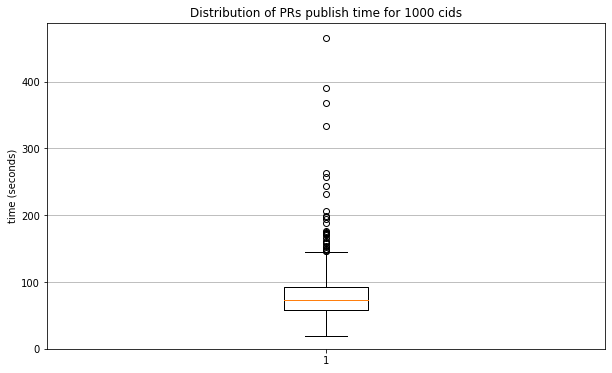

In [15]:
# Quartiles of time to execute IPFS DHT Provide method
pobj = pd.read_sql_query("select provide_time from cid_info order by provide_time ASC", db_con)

pobj["provide_time"] /= 1000 # convert to secods 

fig, ax = plt.subplots()
ax.boxplot(pobj["provide_time"], showfliers=True)
ax.set_ylabel("time (seconds)")
ax.set_ylim(bottom=0) #, top=pobj.iloc[len(pobj)-1]
plt.title(f'Distribution of PRs publish time for {len(pobj)} cids')
plt.grid(axis='y')

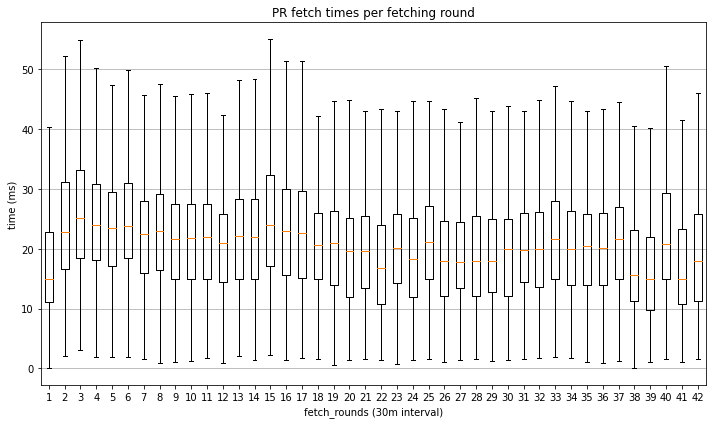

In [7]:
# Get the time to ping PR Holders

# Get the number of rounds that we hoarded
pobj = pd.read_sql_query("select fetch_round from fetch_results group by fetch_round order by fetch_round ASC", db_con)

fetch_time_dist = []
# Get the distribution for each of the rounds
for i, row in pobj.iterrows():
    fpd_round_ftime = pd.read_sql_query(f'select fetch_time from fetch_results where fetch_round={row["fetch_round"]}', db_con) 
    fetch_time_dist.append(fpd_round_ftime['fetch_time'] / 1000 ) # convert to secs

# TODO: remove zeros? 
    
fig, ax = plt.subplots()
ax.boxplot(fetch_time_dist, showfliers=False) 
ax.set_xlabel("fetch_rounds (30m interval)") # TODO: hardcoded to 30 mins?
ax.set_ylabel("time (ms)")
ax.figure.set_size_inches(10, 6)
plt.title("PR fetch times per fetching round")
plt.grid(axis='y')
plt.tight_layout()
plt.show()



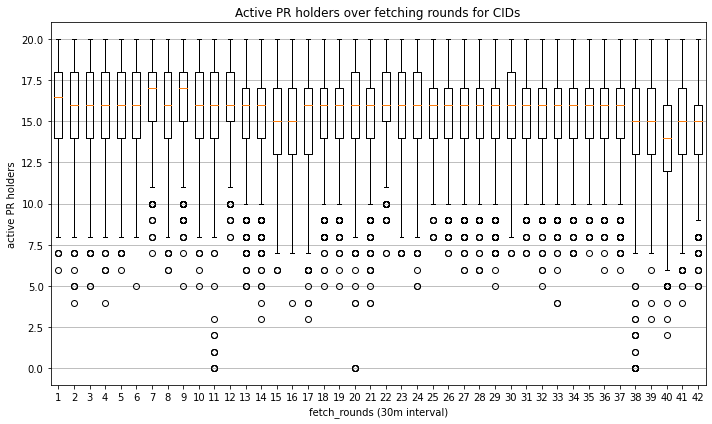

In [8]:
# Get active PR holders over fetch rounds

# TODO: try to remove the Hydras from here


# Get the number of rounds that we hoarded
pobj = pd.read_sql_query("select fetch_round from fetch_results group by fetch_round order by fetch_round ASC", db_con)

succ_att_dist = []
# Get the distribution for each of the rounds
for i, row in pobj.iterrows():
    p = pd.read_sql_query(f'select success_att from fetch_results where fetch_round={row["fetch_round"]}', db_con) 
    succ_att_dist.append(p['success_att'])

fig, ax = plt.subplots()
ax.boxplot(succ_att_dist, showfliers=True) 
ax.set_xlabel("fetch_rounds (30m interval)") # TODO: hardcoded to 30 mins
ax.set_ylabel("active PR holders")
ax.figure.set_size_inches(10, 6)
plt.title(f"Active PR holders over fetching rounds")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [6]:
# Get active PR holders over fetch rounds no hydra peers

# get id of cids
cidobj = pd.read_sql_query("select id, cid_hash from cid_info", db_con)

pr_holders = []
# get peer id that keep the PRs of the cids that are Hydras
for idx, row in cidobj.iterrows():
    aux_array = []
    p_ids = pd.read_sql_query(f"select id from peer_info where cid={row['id']} and client='hydra-booster'", db_con)
    aux_array = p_ids['id'].to_numpy()
    pr_holders.append(aux_array.tolist())


# get the number of pings done on the peers
pingsobj = pd.read_sql_query("select ping_round from ping_results group by ping_round order by ping_round ASC", db_con)

# now that we have the hydras located, see if they are active/have the records
hydra_has_records = []
rest_has_records = []
tot_has_records = []
active_hydras = []
active_rest = []
active_tot = []
for idx, row in pingsobj.iterrows():
    print(f'ping {idx}/{len(pingsobj)}')
    r_has_rec_hy = []
    r_has_rec_no_hy = []
    r_has_rec_tot = []
    r_act_hydras = []
    r_act_no_hydras = []
    r_act_tot = []
    for i, r  in cidobj.iterrows():
        has_rec_hydras = 0
        has_rec_rest = 0
        has_rec_tot = 0
        act_hydras = 0
        act_no_hy = 0
        act_tot = 0
        ping_results = pd.read_sql_query(f"select * from ping_results where ping_round={row['ping_round']} and cid={r['id']}", db_con)
        if len(ping_results) == 0:
            continue
        already_queried = {}
        tot = 0
        for j, item in ping_results.iterrows():
            if item['peer_id'] in already_queried:
                continue
            else:
                already_queried[item['peer_id']] = 1
                
            tot += 1
            if item['is_active']:
                act_tot += 1
                if item['peer_id'] in pr_holders[i] :
                    act_hydras += 1
                else:
                    act_no_hy += 1
                if item['has_records']:
                    has_rec_tot += 1
                    if item['peer_id'] in pr_holders[i] :
                        has_rec_hydras += 1
                    else:
                        has_rec_rest += 1
        if act_tot == 0:
            print(row['ping_round'], r['id'])
            print(ping_results)
        
        if tot > 20:
            print('warn more counts than peers per round')
            print(has_rec_hydras)
            print(has_rec_rest)
            print(has_rec_tot)
            print(act_hydras)
            print(act_no_hy)
            print(act_tot)  
                
        r_has_rec_hy.append(has_rec_hydras)
        r_has_rec_no_hy.append(has_rec_rest)
        r_has_rec_tot.append(has_rec_tot)
        r_act_hydras.append(act_hydras)
        r_act_no_hydras.append(act_no_hy)
        r_act_tot.append(act_tot)

    hydra_has_records.append(r_has_rec_hy)
    rest_has_records.append(r_has_rec_no_hy)
    tot_has_records.append(r_has_rec_tot)
    active_hydras.append(r_act_hydras)
    active_rest.append(r_act_no_hydras)
    active_tot.append(r_act_tot)
    


ping 0/42
ping 1/42
ping 2/42
ping 3/42
ping 4/42
ping 5/42
ping 6/42
ping 7/42
ping 8/42
ping 9/42
ping 10/42
10 753
        id  cid  peer_id  ping_round  fetch_time  is_active  has_records  \
0   214110  753    15040          10      5000.0      False        False   
1   214111  753    15045          10         0.0      False        False   
2   214112  753    15046          10      5001.0      False        False   
3   214113  753    15043          10         0.0      False        False   
4   214114  753    15041          10      5000.0      False        False   
5   214115  753    15049          10      5000.0      False        False   
6   214116  753    15053          10      5000.0      False        False   
7   214117  753    15042          10      5001.0      False        False   
8   214118  753    15044          10      5001.0      False        False   
9   214119  753    15047          10      5001.0      False        False   
10  214120  753    15055          10      5000

ping 11/42
ping 12/42
ping 13/42
ping 14/42
ping 15/42
ping 16/42
ping 17/42
ping 18/42
ping 19/42
19 41
        id  cid  peer_id  ping_round  fetch_time  is_active  has_records  \
0   380462   41      805          19      5000.0      False        False   
1   380463   41      803          19      5000.0      False        False   
2   380464   41      808          19      5000.0      False        False   
3   380465   41      817          19      5000.0      False        False   
4   380466   41      809          19      5001.0      False        False   
5   380467   41      820          19      5001.0      False        False   
6   380468   41      806          19      5001.0      False        False   
7   380469   41      814          19      5000.0      False        False   
8   380470   41      816          19      5001.0      False        False   
9   380471   41      802          19      5002.0      False        False   
10  380472   41      812          19      5001.0      False

ping 20/42
ping 21/42
ping 22/42
ping 23/42
ping 24/42
ping 25/42
ping 26/42
ping 27/42
ping 28/42
ping 29/42
ping 30/42
ping 31/42
ping 32/42
ping 33/42
ping 34/42
ping 35/42
ping 36/42
ping 37/42
37 226
        id  cid  peer_id  ping_round  fetch_time  is_active  has_records  \
0   744144  226     4503          37         0.0      False        False   
1   744145  226      788          37         5.0      False        False   
2   744146  226     4519          37         5.0      False        False   
3   744147  226     4509          37         7.0      False        False   
4   744148  226      789          37        11.0      False        False   
5   744149  226     4506          37         0.0      False        False   
6   744150  226     4512          37        11.0      False        False   
7   744151  226      782          37        11.0      False        False   
8   744152  226      785          37        11.0      False        False   
9   744153  226      795          3

37 240
        id  cid  peer_id  ping_round  fetch_time  is_active  has_records  \
0   744244  240     4792          37         0.0      False        False   
1   744245  240     4787          37         0.0      False        False   
2   744246  240     4788          37         0.0      False        False   
3   744247  240     4791          37         1.0      False        False   
4   744248  240     4789          37         0.0      False        False   
5   744249  240     4790          37         0.0      False        False   
6   744250  240     4800          37         2.0      False        False   
7   744251  240     4796          37         1.0      False        False   
8   744252  240     4781          37         0.0      False        False   
9   744253  240     4799          37         1.0      False        False   
10  744254  240     4795          37         1.0      False        False   
11  744255  240     4794          37         2.0      False        False   
12  7

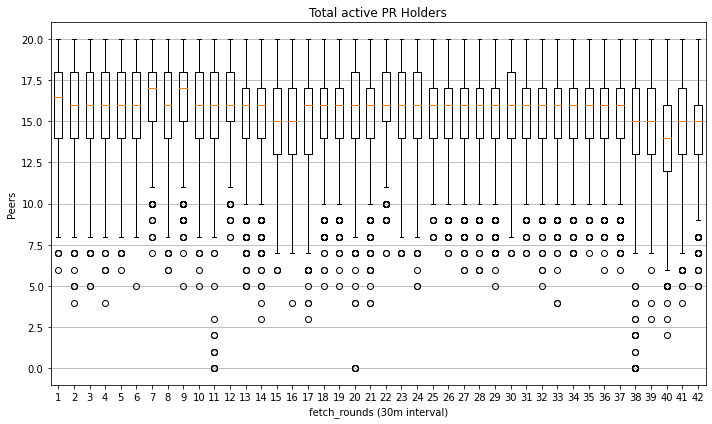

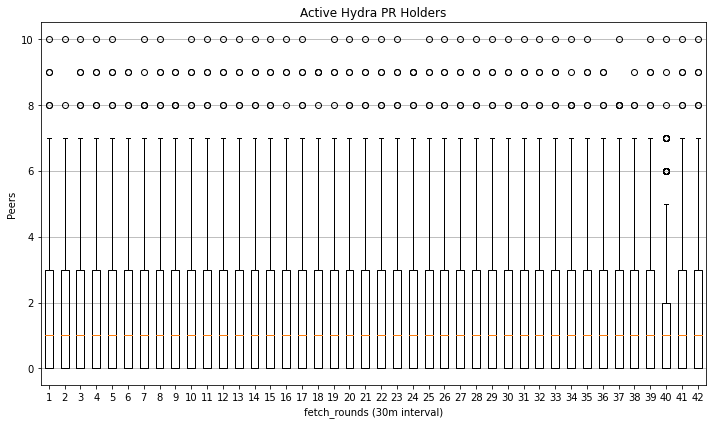

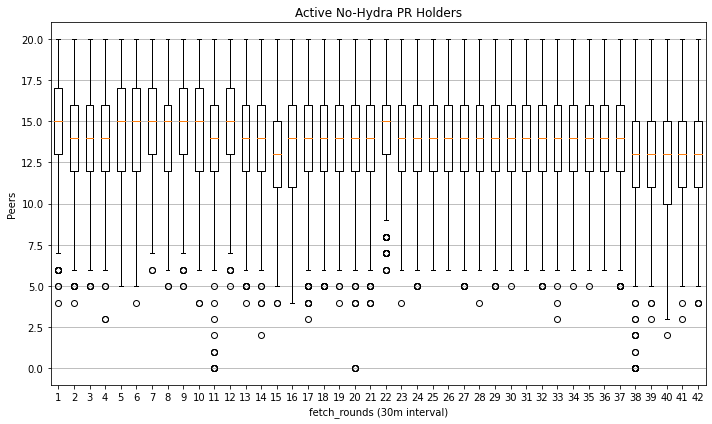

In [12]:
# plot the active / has_records quartiles

# active hydras vs active no hydras
fig, ax = plt.subplots()
ax.boxplot(active_tot, showfliers=True) 
ax.set_title("Total active PR Holders")
ax.set_xlabel("fetch_rounds (30m interval)") # TODO: hardcoded to 30 mins
ax.set_ylabel("Peers")
ax.figure.set_size_inches(10, 6)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots()
ax.boxplot(active_hydras, showfliers=True) 
ax.set_title("Active Hydra PR Holders")
ax.set_xlabel("fetch_rounds (30m interval)") # TODO: hardcoded to 30 mins
ax.set_ylabel("Peers")
ax.figure.set_size_inches(10, 6)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots()
ax.boxplot(active_rest, showfliers=True) 
ax.set_title("Active No-Hydra PR Holders")
ax.set_xlabel("fetch_rounds (30m interval)") # TODO: hardcoded to 30 mins
ax.set_ylabel("Peers")
ax.figure.set_size_inches(10, 6)
plt.grid(axis='y')
plt.tight_layout()
plt.show()



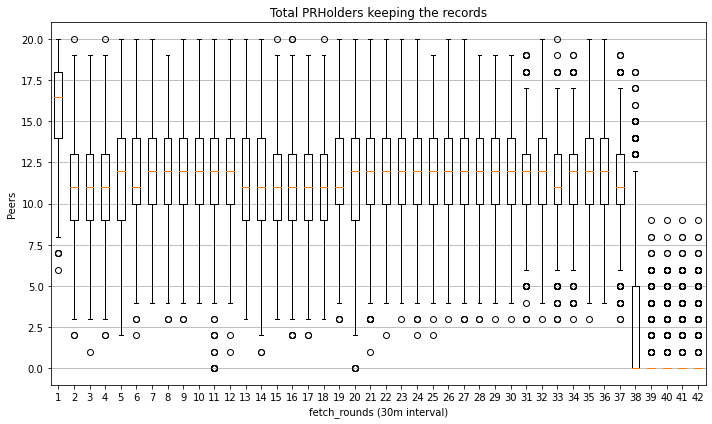

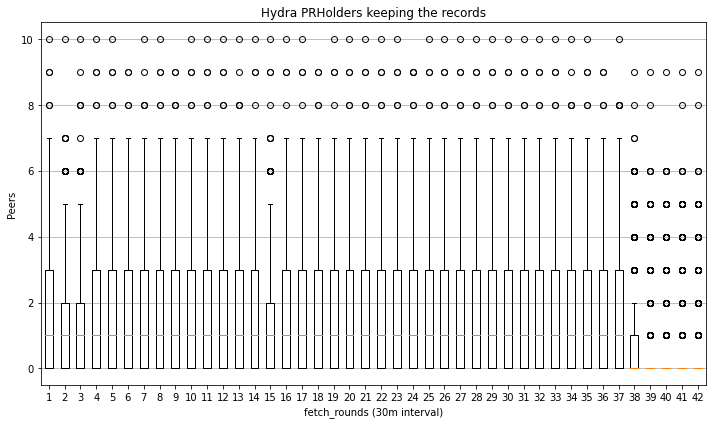

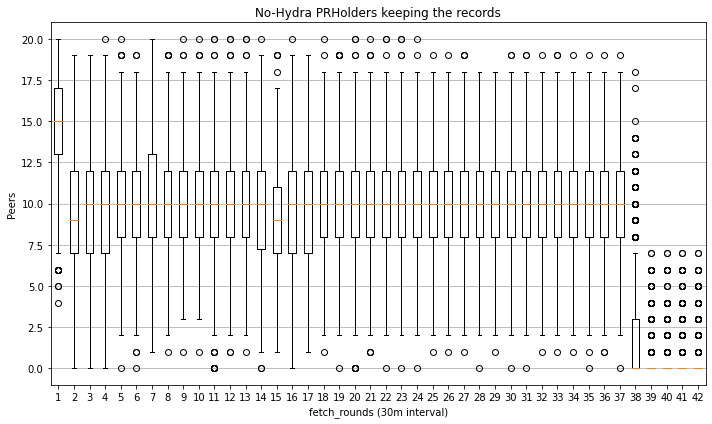

In [13]:

# has_records hydras vs active no hydras
fig, ax = plt.subplots()
ax.boxplot(tot_has_records, showfliers=True) 
ax.set_title("Total PRHolders keeping the records")
ax.set_xlabel("fetch_rounds (30m interval)") # TODO: hardcoded to 30 mins
ax.set_ylabel("Peers")
ax.figure.set_size_inches(10, 6)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots()
ax.boxplot(hydra_has_records, showfliers=True) 
ax.set_title("Hydra PRHolders keeping the records")
ax.set_xlabel("fetch_rounds (30m interval)") # TODO: hardcoded to 30 mins
ax.set_ylabel("Peers")
ax.figure.set_size_inches(10, 6)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots()
ax.boxplot(rest_has_records, showfliers=True) 
ax.set_title("No-Hydra PRHolders keeping the records")
ax.set_xlabel("fetch_rounds (30m interval)") # TODO: hardcoded to 30 mins
ax.set_ylabel("Peers")
ax.figure.set_size_inches(10, 6)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

16
{'max_dial_attempts_exceeded': 0, 'negotiate_security_protocol_no_trailing_new_line': 0, 'stream_reset': 0, 'no_good_addresses': 0, 'protocol_not_supported': 0, 'peer_id_mismatch': 0, 'no_route_to_host': 0, 'unknown': 0, 'network_unreachable': 0, 'context_deadline_exceeded': 0, 'connection_refused': 0, 'io_timeout': 0, 'none': 0}


Text(0.5, 1.0, 'Error distribution over fetch rounds')

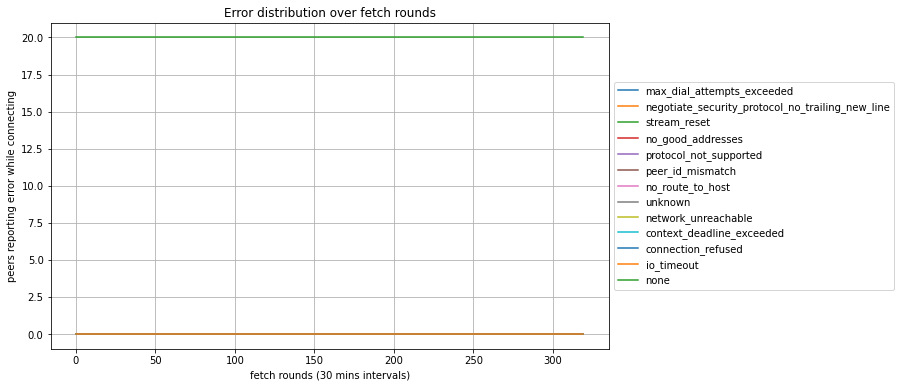

In [18]:
# Analyze the error of those peers that got connected successfully to 0 peers while fetching

# get index of ping rounds and cids that got the 0 total active peers
ping_cid_dict = {"ping_round": [], "cid": []}
for idx, d in enumerate(active_tot):
    for i, c in enumerate(d):
        if c == 0:
            ping_cid_dict['ping_round'].append(idx)
            ping_cid_dict['cid'].append(i)  
print(len(ping_cid_dict['cid']))
            
# get list of errors from the entire pings
errorsobj = pd.read_sql_query('select conn_error, count(conn_error) from ping_results group by conn_error order by count(conn_error)', db_con)

err_dist = {}
for i, r in errorsobj.iterrows():
    err_dist[r['conn_error']] = []  

errs = {}   
for i, r in errorsobj.iterrows():
    errs[r['conn_error']] = 0
print(errs)    
    
for idx, ping in enumerate(ping_cid_dict['ping_round']):
    errorsobj = pd.read_sql_query(f'select peer_id, ping_round, conn_error from ping_results where ping_round={ping} and cid={ping_cid_dict["cid"][idx]}', db_con)
    for idx, row in errorsobj.iterrows():
        errors = errs.copy()
         
        already_queried = {}
        for j, item in ping_results.iterrows():
            if item['peer_id'] in already_queried:
                continue
            else:
                already_queried[item['peer_id']] = 1
                
            errors[item['conn_error']]+= 1
            
        for err in errors:
            err_dist[err].append(errors[err])

       
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
         
for k in err_dist:
    if len(err_dist[k]) > 0:
        ax.plot(err_dist[k], label=k)

ax.set_xlabel('fetch rounds (30 mins intervals)')
ax.set_ylabel('peers reporting error while connecting')
ax.legend()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid()
plt.title('Error distribution over fetch rounds')

          client  count  client percentage
0        go-ipfs  13605          68.028401
1  hydra-booster   3900          19.500975
2  NotIdentified   2165          10.825541
3          storm    236           1.180059
4         Others     71           0.355018
5            ioi     22           0.110006


Text(0.5, 1.0, 'Client type on PR Holders')

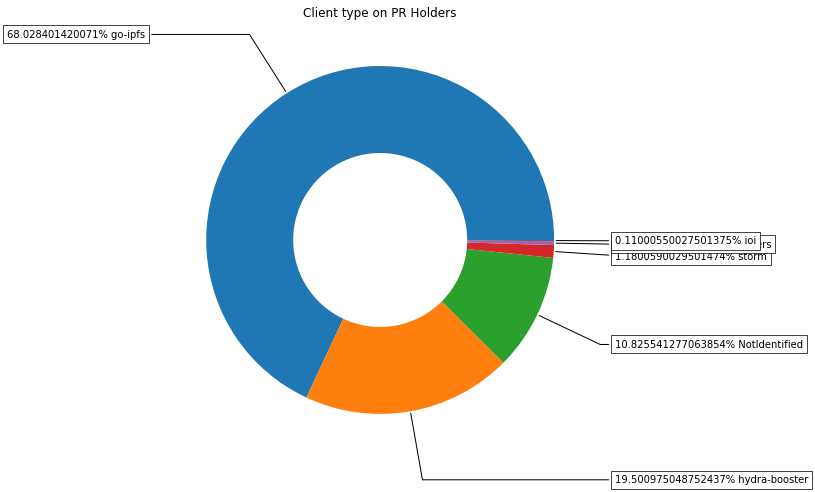

In [26]:
# Get client distribution on PR Holders
pobj = pd.read_sql_query("select client, count(client) from peer_info group by client order by count(client) DESC;", db_con)

total = 0
for i, c in pobj.iterrows():
    total += c["count"]
    
# get the percentage of each client
pobj["client percentage"] = (pobj["count"] * 100) / total
print(pobj)

# compose labels
labels = []
for i, row in pobj.iterrows():
    r = f'{row["client percentage"]}% {row["client"]}'
    labels.append(r)
    
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw=dict(aspect="equal"))
wedges, texts = ax.pie(pobj['client percentage'], wedgeprops=dict(width=0.5))#, startangle=-40)

# Generate the text boxes with the legend and percentajes 
bbox_props = dict(boxstyle="square,pad=0.4", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(labels[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)

ax.set_title("Client type on PR Holders")


[13.605, 3.9, 0.236, 0.022, 0.0, 0.071, 2.165]


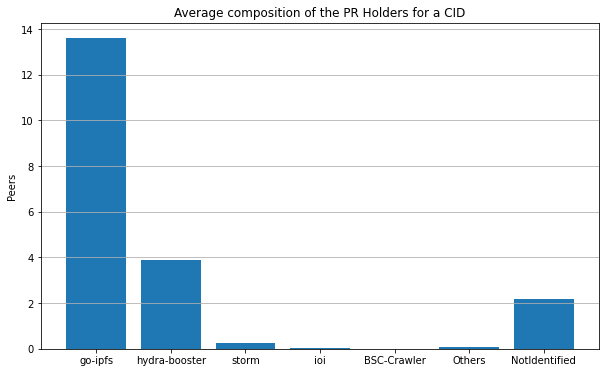

In [27]:
# Get number of Hyda boosters as PR Holders

cids = pd.read_sql_query("select id, cid_hash from cid_info", db_con)

# get the client type distribution for each of the cids
aggregations = []
for i, row in cids.iterrows():
    client_dist = {"go-ipfs": 0.0, "hydra-booster": 0.0, "storm": 0.0, "ioi": 0.0, "BSC-Crawler": 0.0 ,"Others": 0.0, "NotIdentified": 0.0}
    c = pd.read_sql_query(f'select client, count(client) from peer_info where cid={row["id"]} group by client order by client', db_con)

    tot = 0
    for i, r in c.iterrows():
        tot += r["count"]
        
    for i, r in c.iterrows():
        client_dist[r["client"]] = r["count"] # (r["count(client)"] * 100) / tot 
    
    agg = []
    agg.append(client_dist["go-ipfs"])
    agg.append(client_dist["hydra-booster"])
    agg.append(client_dist["storm"])
    agg.append(client_dist["ioi"])
    agg.append(client_dist["BSC-Crawler"])
    agg.append(client_dist["Others"])
    agg.append(client_dist["NotIdentified"])

    aggregations.append(agg)

# Get avg of the client_dist 
aggts = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
for item in aggregations:
    aggts += np.array(item)
    
avgs = []
for item in aggts:
    avgs.append(item / len(aggregations))
    
print(avgs)

l = ["go-ipfs", "hydra-booster", "storm", "ioi", "BSC-Crawler", "Others", "NotIdentified"]
plt.bar(l, avgs)
plt.title("Average composition of the PR Holders for a CID")
plt.ylabel("Peers") # TODO: hardcoded to 30 mins   
plt.grid(axis='y')
    

Text(0.5, 1.0, 'Error distribution over fetch rounds')

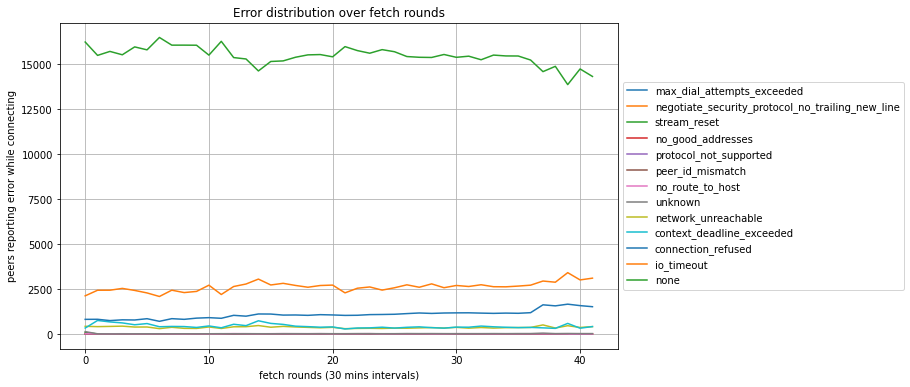

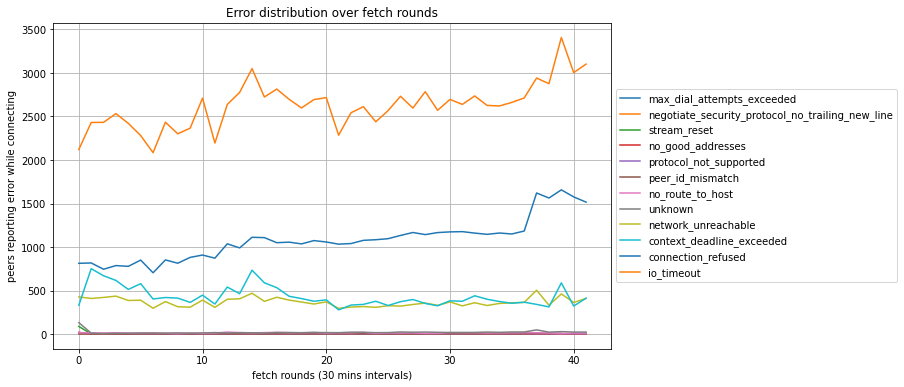

In [34]:
# Check the error getting connecting PR Holders

# get cids
cidobj = pd.read_sql_query('select id, cid_hash from cid_info', db_con)

# get list of errors from the entire pings
errorsobj = pd.read_sql_query('select conn_error, count(conn_error) from ping_results group by conn_error order by count(conn_error)', db_con)

pingsobj = pd.read_sql_query("select ping_round from ping_results group by ping_round order by ping_round ASC", db_con)

err_dist = {}
for i, r in errorsobj.iterrows():
    err_dist[r['conn_error']] = []
    
for i, r in pingsobj.iterrows():
    errorsobj = pd.read_sql_query(f'select conn_error, count(conn_error) from ping_results where ping_round={r["ping_round"]} group by conn_error order by count(conn_error) ASC', db_con)
    for idx, row in errorsobj.iterrows():
        err_dist[row["conn_error"]].append(row["count"])

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

for k in err_dist:
    ax.plot(err_dist[k], label=k)
    
ax.set_xlabel('fetch rounds (30 mins intervals)')
ax.set_ylabel('peers reporting error while connecting')
ax.legend()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid()
plt.title('Error distribution over fetch rounds')


    
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

for k in err_dist:
    if k == 'none':
        continue
    ax.plot(err_dist[k], label=k)
    
ax.set_xlabel('fetch rounds (30 mins intervals)')
ax.set_ylabel('peers reporting error while connecting')
ax.legend()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid()
plt.title('Error distribution over fetch rounds')    
    
